In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from subprocess import call

In [93]:
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [94]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [95]:
# You can also drop whichever other columns you'd like here
titanic_df.drop("Cabin", axis=1, inplace=True)

In [96]:
# impute missing age data.
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].mean())
# drop records with embarked empty
titanic_df.dropna(inplace=True)


Age is assumed missing at random, so hopefully filling up with column average won't skew the data much. Seems like a better solution than deleting over 200 records.

In [97]:
# Name and ticket info not needed in analysis
titanic_df.drop(["Name", "Ticket"], axis=1, inplace=True)

In [98]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 69.5+ KB


### One-Hot Encoding
One-hot encoding is a technique used to ensure that categorical variables are better represented in the machine. Let's take a look at the "Sex" column

In [99]:
titanic_df["Sex"].unique()

array(['male', 'female'], dtype=object)

Machine Learning classifiers don't know how to handle strings. As a result, you need to convert it into a categorical representation. There are two main ways to go about this:

Label Encoding: Assigning, for example, 0 for "male" and 1 for "female". The problem here is it intrinsically makes one category "larger than" the other category.

One-hot encoding: Assigning, for example, [1, 0] for "male" and [0, 1] for female. In this case, you have an array of size (n_categories,) and you represent a 1 in the correct index, and 0 elsewhere. In Pandas, this would show as extra columns. For example, rather than having a "Sex" column, it would be a "Sex_male" and "Sex_female" column. Then, if the person is male, it would simply show as a 1 in the "Sex_male" column and a 0 in the "Sex_female" column.

There is a nice and easy method that does this in pandas: get_dummies()

In [100]:
titanic_df = pd.get_dummies(titanic_df, prefix="Sex", columns=["Sex"])
titanic_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
0,1,0,3,22.0,1,0,7.2500,S,False,True
1,2,1,1,38.0,1,0,71.2833,C,True,False
2,3,1,3,26.0,0,0,7.9250,S,True,False
3,4,1,1,35.0,1,0,53.1000,S,True,False
4,5,0,3,35.0,0,0,8.0500,S,False,True


Now, we do the same to the "Embarked" column.

In [101]:
titanic_df = pd.get_dummies(titanic_df, prefix="Embarked", columns=["Embarked"])
titanic_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,2,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,3,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,4,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,5,0,3,35.0,0,0,8.0500,False,True,False,False,True


<Axes: >

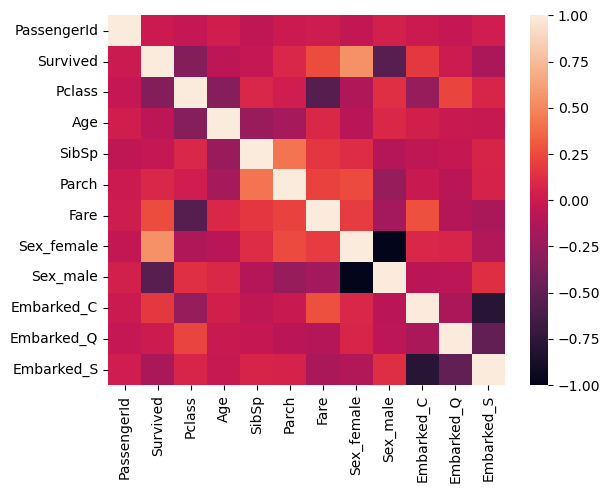

In [102]:
# which features should be considered when making the decision tree classifier
cm = titanic_df[titanic_df.columns].corr()
sns.heatmap(cm)

In [103]:
# assign X and y
X = titanic_df.iloc[:,2:]
y = titanic_df['Survived']

# split x and y into train and test
rand = 0
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rand)

# split train set into train and development
X_train, X_dev, y_train, y_dev = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=rand, stratify=y_train_full)

# create decision tree with no limit on max depth
predict_survival = DecisionTreeClassifier(max_depth=None, random_state=rand)
# fit decision tree on training data
predict_survival.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [104]:
# get predicted values
y_pred = predict_survival.predict(X_dev)



In [105]:
titanic_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [108]:
print(predict_survival.max_depth)
print("Accuracy of training set with no limitations on depth:", predict_survival.score(X_dev, y_dev))

None
Accuracy of training set with no limitations on depth: 0.7482517482517482


In [63]:
predict_survival.score(X_dev, y_dev)

0.7972027972027972

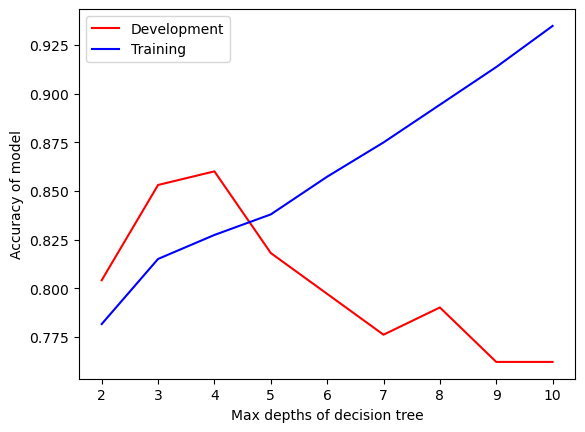

In [113]:
# accuracy vs max depth of model
depths = range(2,11)
accuracies =[]
train_accs = []
# loop through range. create and test decision trees for multiple depths
for depth in depths:
    predictor = DecisionTreeClassifier(max_depth=depth, random_state=rand)
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_dev)
    # store accuracy info in lists.
    train_accs.append(predictor.score(X_train, y_train))
    accuracies.append(predictor.score(X_dev, y_dev))
    

# plot depths vs accuracy
fig, ax = plt.subplots()
ax.plot(depths, accuracies, color='r', label="Development")
ax.plot(depths, train_accs, color = 'b', label='Training')
plt.xlabel("Max depths of decision tree")
plt.ylabel("Accuracy of model")
plt.legend()
plt.show()



Accuracy of the model on training data increases with depth, but this does not generalise to development data. I.e., the high-depth models have been overfitted to the training data. Best performance for development data is at a depth of 4.

In [110]:
# select depth with best accuracy
best = depths[np.argmax(accuracies)]
# create model at best depth
final_model = DecisionTreeClassifier(max_depth=best)
final_model.fit(X_train, y_train)

# use model on test data
y_pred = final_model.predict(X_test)

# model score
print("Pruned model score on test data:", final_model.score(X_test, y_test))

Pruned model score on test data: 0.8595505617977528


In [114]:
# from example file
export_graphviz(final_model, out_file='titanic.dot', feature_names = titanic_df.columns[2:],
                  rounded = True, proportion = False, precision = 2, filled = True)
# Convert to png 
call(['dot', '-Tpng', 'titanic.dot', '-o', 'titanic.png', '-Gdpi=600'])

0

image uploaded in folder.